In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [38]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')

## Значения колонок

#### survival - Выживший 0 = Нет, 1 = Да
#### pclass - Класс билета 1 = первый, 2 = второй, 3 = третий
#### sex - Пол
#### Age - Возраст (в годах)
#### sibsp - количество братьев и сестер/супругов на борту Титаника
#### parch - количество родителей/детей на борту Титаника
#### ticket - номер билета
#### fare - стоимость билета
#### cabin - номер кают
#### embarked - порт отправки C = Cherbourg, Q = Queenstown, S = Southamptonuthampton= Southampton

# EDA и Feature Engineering

In [39]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

### 1. Теория : люди, имеющие родственников на борту выживали меньше


 Добавляем колонку для счета количества радственников

In [40]:
train_df['number_of_relatives'] = train_df['Parch'] + train_df['SibSp']

Визуальная демонстрация результата теории представлена ниже

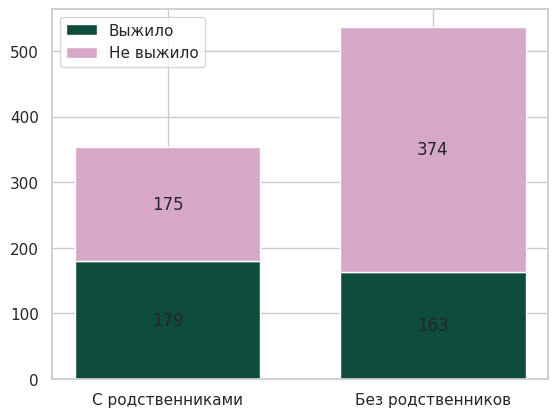

In [41]:
import matplotlib.pyplot as plt

survived_with_relatives = len(train_df[(train_df.number_of_relatives > 0) & (train_df.Survived == 1.0)])
not_survived_with_relatives = len(train_df[(train_df.number_of_relatives > 0) & (train_df.Survived == 0)])

survived_without_relatives = len(train_df[(train_df.number_of_relatives == 0) & (train_df.Survived == 1.0)])
not_survived_without_relatives = len(train_df[(train_df.number_of_relatives == 0) & (train_df.Survived == 0)])

name_value = ('С родственниками', 'Без родственников')

labels = {
    'Выжило': np.array([survived_with_relatives, survived_without_relatives]),
    'Не выжило': np.array([not_survived_with_relatives, not_survived_without_relatives]),
}

colors = ['#0E4C3B', '#D6A7C6']

width = 0.7
fig, ax = plt.subplots()
bottom = np.zeros(2)

for i, (label, amount) in enumerate(labels.items()):
    p = ax.bar(name_value, amount, width, label=label, bottom=bottom, color=colors[i])
    bottom += amount

    ax.bar_label(p, label_type='center')

ax.legend()

plt.show()


 Вывод : люди, у которых были родственники выживали куда чаще, чем те, у кого их не было, я думаю это произошло из-за того, что каждый человек переживает за члена своей семьи и поэтому помогает ему спастись

### 2. Теория : выживаемость людей зависила от класса их билета (чем лучше класс - тем дольше шансов выжить)

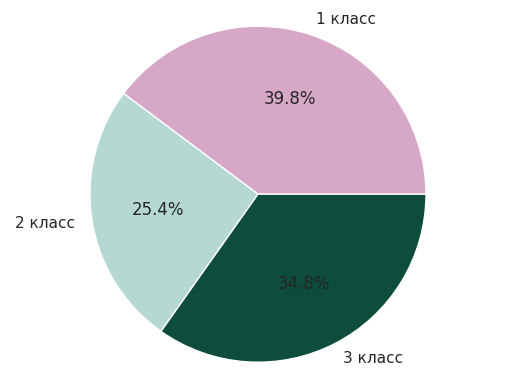

In [42]:
class_1 = len(train_df[(train_df.Pclass == 1) & (train_df.Survived == 1)])
class_2 = len(train_df[(train_df.Pclass == 2) & (train_df.Survived == 1)])
class_3 = len(train_df[(train_df.Pclass == 3) & (train_df.Survived == 1)])

labels = ["1 класс", "2 класс", "3 класс"]
nums = [class_1, class_2, class_3]

colors = ['#D6A7C6', '#B5D8D2', '#0E4C3B']

fig, ax = plt.subplots()
ax.pie(nums, labels=labels, colors=colors, autopct='%1.1f%%')

ax.axis('equal')  # Сохраняем равное соотношение сторон
plt.show()

 Вывод : Данный срез показал, что люди 1 и 3 класса выживали больше, но это выглядит не совсем логичным при учитывании факта размещения кабин на титанеке, поэтому проверим данную теорию еще одинм способом (количеством выживших людей для каждого класса)

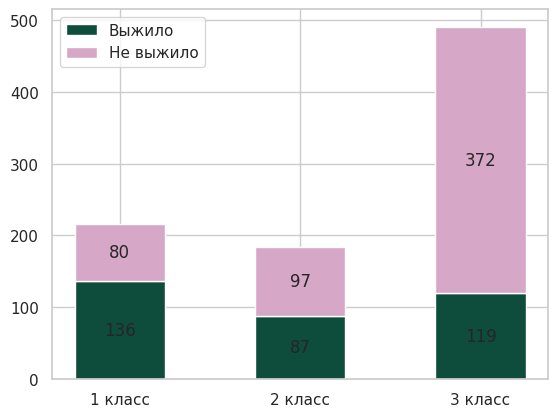

In [43]:
class_1 = len(train_df[(train_df.Pclass == 1) & (train_df.Survived == 1)])
class_2 = len(train_df[(train_df.Pclass == 2) & (train_df.Survived == 1)])
class_3 = len(train_df[(train_df.Pclass == 3) & (train_df.Survived == 1)])

class_1_not_survived = len(train_df[(train_df.Pclass == 1) & (train_df.Survived == 0)])
class_2_not_survived = len(train_df[(train_df.Pclass == 2) & (train_df.Survived == 0)])
class_3_not_survived = len(train_df[(train_df.Pclass == 3) & (train_df.Survived == 0)])

name_value1 = ('1 класс', '2 класс', '3 класс')
labels = {
    'Выжило': np.array([class_1, class_2, class_3]),
    'Не выжило': np.array([class_1_not_survived, class_2_not_survived, class_3_not_survived]),
}

width = 0.5 
colors = ['#0E4C3B', '#D6A7C6']
fig, ax = plt.subplots()
bottom = np.zeros(3)

for i, (label, amount) in enumerate(labels.items()):
    p = ax.bar(name_value1, amount, width, label=label, bottom=bottom, color=colors[i])
    bottom += amount

    ax.bar_label(p, label_type='center')

ax.legend()

plt.show()

Вывод: вот теперь можно увидеть действительный расклад, здесь видно, что на самом деле 3 класс выживал куда реже, чем 1 и 2. При этом в результате вдух выборок видно, что 1 класс выживал больше всего (данный класс был расположен ближе к палубе титаника, что позволяло быстрее выбраться при обнаружении айсберга, а так же увеличивало скорость посадки в спасательную шлюбку/лодку)

### 3. Теория : зависимость частоты выживания от возраста пассажира. Дети спасались чаще, чем взрослые люди

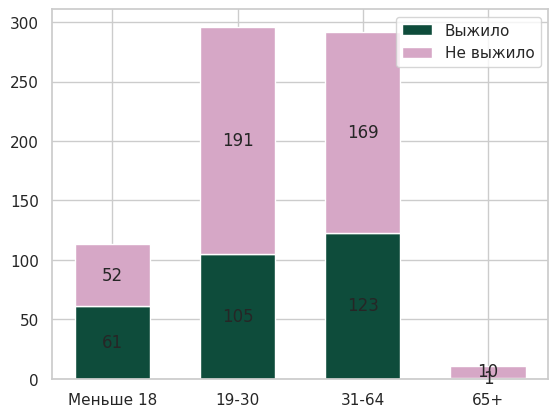

In [44]:
less_18 = len(train_df[(train_df.Age < 18) & (train_df.Survived == 1.0)])
under_18_not_survived = len(train_df[(train_df.Age < 18) & (train_df.Survived == 0)])

from_18_to_30 = len(train_df[((train_df.Age >= 18) & (train_df.Age <= 30)) & (train_df.Survived == 1)])
from_18_to_30_not_survived = len(train_df[((train_df.Age >= 18) & (train_df.Age <= 30)) & (train_df.Survived == 0)])

from_31_to_64 = len(train_df[((train_df.Age >= 31) & (train_df.Age <= 64)) & (train_df.Survived == 1)])
from_31_to_64_not_survived = len(train_df[((train_df.Age >= 31) & (train_df.Age <= 64)) & (train_df.Survived == 0)])

more_65= len(train_df[(train_df.Age > 64) & (train_df.Survived == 1.0)])
more_65_not_survived = len(train_df[(train_df.Age > 64) & (train_df.Survived == 0)])


names = ('Меньше 18', '19-30', '31-64', '65+')
labels = {
    'Выжило': np.array([less_18, from_18_to_30, from_31_to_64, more_65]),
    'Не выжило': np.array([under_18_not_survived, from_18_to_30_not_survived, from_31_to_64_not_survived, more_65_not_survived]),
}

width = 0.6 
colors = ['#0E4C3B', '#D6A7C6']

fig, ax = plt.subplots()
bottom = np.zeros(4)

for i, (label, amount) in enumerate(labels.items()):
    p = ax.bar(names, amount, width, label=label, bottom=bottom, color=colors[i % len(colors)])  
    bottom += amount

    ax.bar_label(p, label_type='center')
    
ax.legend()
plt.show()

Вывод : Доля выживших детей стотавила почти 50%, что является лучшим покажателем среди возрастов, а вот люди 65+ сотсавиили всего лишь 10%, вероятнее всего они отдавали свои места в спасательных шлюбках для молодых, так как видили, что мест там не много

### 4. Теория : женщины выживали чаще, чем мужчина (выживание по половому признаку)

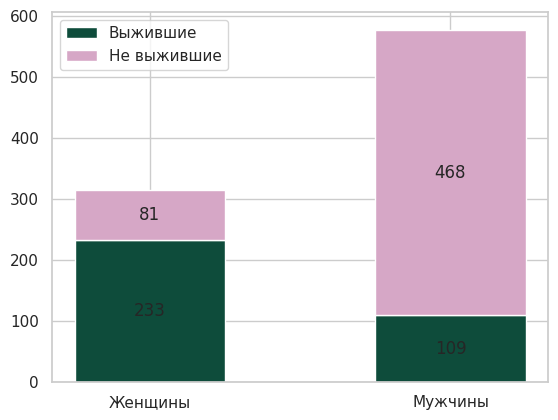

In [45]:
female = len(train_df[(train_df.Sex == 'female') & (train_df.Survived == 1)])
female_not_survived = len(train_df[(train_df.Sex == 'female') & (train_df.Survived == 0)])

male = len(train_df[(train_df.Sex == 'male') & (train_df.Survived == 1)])
male_not_survived = len(train_df[(train_df.Sex == 'male') & (train_df.Survived == 0)])


labels = {
    'Выжившие': np.array([female, male]),
    'Не выжившие': np.array([female_not_survived, male_not_survived]),
}

names = ['Женщины', 'Мужчины']
width = 0.5
colors = ['#0E4C3B', '#D6A7C6']  
fig, ax = plt.subplots()
bottom = np.zeros(2)


for i, (label, amount) in enumerate(labels.items()):
    p = ax.bar(names, amount, width, label=label, bottom=bottom, color=colors[i])
    bottom += amount  

    ax.bar_label(p, label_type='center')

ax.legend()
plt.show()

Вывод : женщины выживали чаще, чем мужчины - это логично, ведь в обществе принято спасать сначала женщин и детей, а потом уже мужчин, но я хочу проверить зависит ли выживаемость от пола и возраста

Проверим наличие пустых значений

In [46]:
# объединяем два датасета
df = pd.concat([train_df, test_df], ignore_index=True) 

In [47]:
#проверка на пропуски
df.isnull().sum()

PassengerId               0
Survived                418
Pclass                    0
Name                      0
Sex                       0
Age                     263
SibSp                     0
Parch                     0
Ticket                    0
Fare                      1
Cabin                  1014
Embarked                  2
number_of_relatives     418
dtype: int64

 Начнем с пустых строчек в возрасте. Определенный диапазон для среднего значения выбирать нет смысла, ведь пассажиры зарегестрированы хаотично, поэтому я посчтиала целесообразным заменить средним значением по всем столбцам

In [48]:
# вычисление среднего значения без учета пропусков
mean_age = df['Age'].mean()
df['Age'] = df['Age'].fillna(mean_age)

# убираем доли у возраста
df['Age'] = df['Age'].round().astype(int)


df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,number_of_relatives
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1.0


Заполняем пропуски в столбце Cabin "0"

In [49]:
df['Cabin'] = df['Cabin'].fillna(0)

In [50]:
# смотрим уникальные значения
df.Embarked.value_counts()

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

Самый популярный порт был первый, поэтому заменим пропуски данным значением

In [51]:
df['Embarked'] = df['Embarked'].fillna('S')

In [52]:
# Проверяем восполнили мы все пропуски
df.isnull().sum()

PassengerId              0
Survived               418
Pclass                   0
Name                     0
Sex                      0
Age                      0
SibSp                    0
Parch                    0
Ticket                   0
Fare                     1
Cabin                    0
Embarked                 0
number_of_relatives    418
dtype: int64

Оставим в стлобце Cabin лишь литеру

In [53]:
# функция для преобразования кабины
def letter_from_cabin(cabin):
    if isinstance(cabin, str) and cabin: #проверка не пустая ли строка
        splitted = cabin.split()
        if len(splitted) == 1:
            return splitted[0][0]
        for x in splitted:
            for n in '0123456789':
                if n in x:
                    return x[0]
            
df['Cabin'] = df['Cabin'].apply(letter_from_cabin)

Выделим фамилию отдельно, чтобы помочь моделям в дальнейшем проще определять родственность пассажиров

In [54]:
#Создаем функцию, которая в столбце Name оставляет только фамилию

def last_name(full_name):
    return full_name.split()[0][:-1]

df['Name'] = df['Name'].apply(last_name)

df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,number_of_relatives
0,1,0.0,3,Braund,male,22,1,0,A/5 21171,7.2500,None,S,1.0
1,2,1.0,1,Cumings,female,38,1,0,PC 17599,71.2833,C,C,1.0
2,3,1.0,3,Heikkinen,female,26,0,0,STON/O2. 3101282,7.9250,None,S,0.0


Добавим получившие обновления с столбцах с фамилией и литерой кабины в соответсвующие списки с уникальными значениями

In [55]:
unique_cabins = list(df['Cabin'].unique())
unique_names = list(df['Name'].unique())

Далее преобразуем данные из категориальных в числовие с помошью LabelEncoder и OneEncoder

Колонку с фамилией преобрахуем с помощью LabelEncoder из-за разнообразия фамилий, а Sex, Embarked, Cabin - OneEncoder

In [56]:
df['Sex'] = df['Sex'].astype(str)
df['Embarked'] = df['Embarked'].astype(str)
df['Cabin'] = df['Cabin'].astype(str)

In [57]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

result = OneHotEncoder().fit_transform(df['Sex'].values.reshape(-1, 1)).toarray()
df[['Female', 'Male']] = pd.DataFrame(result, index = df.index)


result = OneHotEncoder().fit_transform(df['Embarked'].values.reshape(-1, 1)).toarray()
df[['Cherbourg', 'Queenstown', 'Southampton']] = pd.DataFrame(result, index = df.index)


result = OneHotEncoder().fit_transform(df['Cabin'].values.reshape(-1, 1)).toarray()
df[unique_cabins] = pd.DataFrame(result, index = df.index)

LE = LabelEncoder()
LE.fit(unique_names)
df['Name'] = LE.fit_transform(df['Name'])

df = df.drop(['Sex', 'Embarked', 'Cabin'], axis=1)

In [58]:
df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,number_of_relatives,...,Southampton,None,C,E,G,D,A,B,F,T
0,1,0.0,3,100,22,1,0,A/5 21171,7.2500,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1.0,1,182,38,1,0,PC 17599,71.2833,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,3,329,26,0,0,STON/O2. 3101282,7.9250,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,1.0,1,267,35,1,0,113803,53.1000,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,3,15,35,0,0,373450,8.0500,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,753,30,0,0,A.5. 3236,8.0500,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1305,1306,NaN,1,593,39,0,0,PC 17758,108.9000,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,1307,NaN,3,699,38,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1307,1308,NaN,3,823,30,0,0,359309,8.0500,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [59]:
df = df.drop(['Ticket', 'PassengerId'], axis=1)

сделаем срез нашего датасета по строкам, где есть результат выживания

In [60]:
survived_col = df["Survived"][:891]

# удаляем столбец из датасета, раз мы сохранили данные в survived_col
# и пустые строки с этом столбце нам не нужны
df = df.drop(["Survived"], axis=1)

In [61]:
# разделим вновь датасет на тестовую и обучающую выборку
test_df = df[891:] 
train_df = df[:891] 
train_df

,Pclass,Name,Age,SibSp,Parch,Fare,number_of_relatives,Female,Male,Cherbourg,...,Southampton,None,C,E,G,D,A,B,F,T
0,3,100,22,1,0,7.2500,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,182,38,1,0,71.2833,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,329,26,0,0,7.9250,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,267,35,1,0,53.1000,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,15,35,0,0,8.0500,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,535,27,0,0,13.0000,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
887,1,294,19,0,0,30.0000,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,3,383,30,1,2,23.4500,3.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
889,1,69,26,0,0,30.0000,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Нормализуем датасет для обучения

In [62]:
from sklearn.preprocessing import StandardScaler

train_df.columns = train_df.columns.astype(str)
test_df.columns = test_df.columns.astype(str)

# Удаляем столбцы с именем None
train_df = train_df.loc[:, train_df.columns.notnull()]
test_df = test_df.loc[:, test_df.columns.notnull()]


scaler = StandardScaler()

numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

scaler.fit(train_df[numeric_cols])

train_df = pd.DataFrame(scaler.transform(train_df[numeric_cols]), columns=numeric_cols, index=train_df.index)
test_df = pd.DataFrame(scaler.transform(test_df[numeric_cols]), columns=numeric_cols, index=test_df.index)


### ВЫВОД
#### Проанализировала данные в датасете, выявила зависимость некоторых признаков, заполнила пропуски, добавила новые фичи и нормализовала датасет с помощьюStandardScaler


### Работа с моделями

Для начала выявим корреляцию признаков с учетом новых

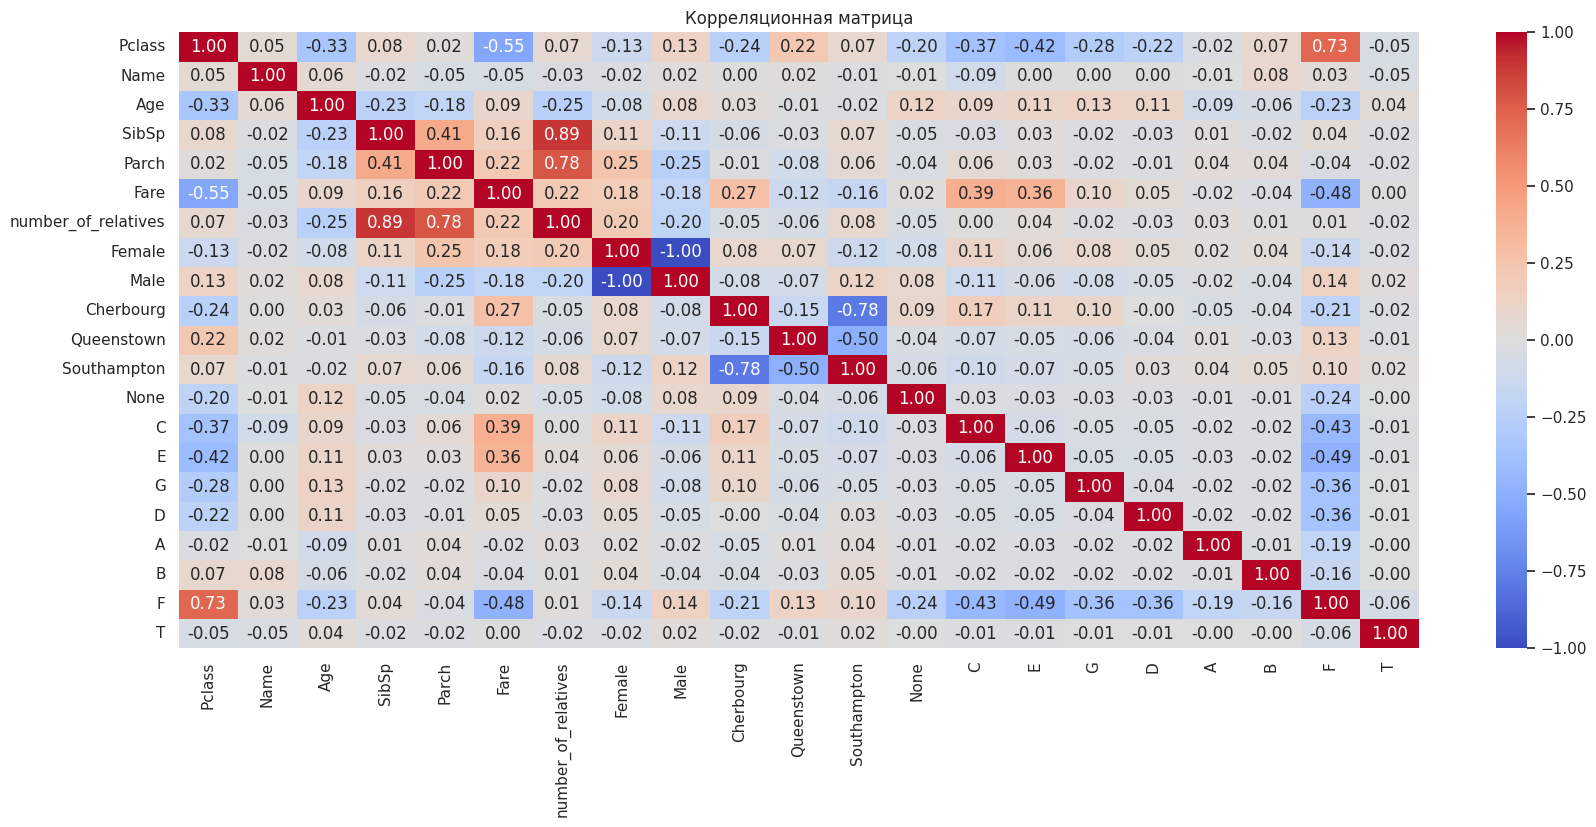

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = train_df.corr()

plt.figure(figsize=(20, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

Вывод: Новые признаки относительно росдтва коррелируют только в двумя значениями, от которых они и было созданы, а вот литеры кают не коррелируют с другими признаками

Разделем датасет на данные для обучения

In [64]:
from sklearn.model_selection import train_test_split

X = train_df
y = survived_col

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [65]:
from sklearn import svm
clf = svm.SVC(kernel='poly', C=20).fit(x_train, y_train)
clf.score(x_test, y_test)

0.7847533632286996

Вывод: модель показала неплохой результат, рассмотрим другую модель

 Теперь рассмотрим GradientBoostingClassifier

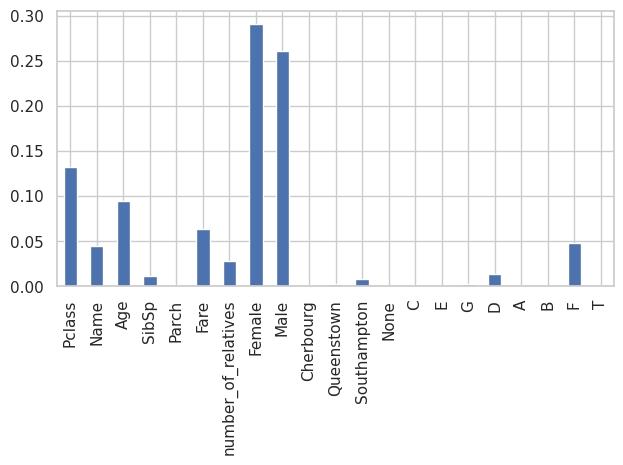

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

GBC = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=3, min_samples_leaf=5, min_samples_split=9, criterion='squared_error')
GBC.fit(x_train,y_train)

column_names = list(x_train.columns)
feature_names = [column_names[i] for i in range(X.shape[1])]
importances = GBC.feature_importances_
gbc_importances = pd.Series(importances, index=feature_names)

# выведим график показывающий значимость категории для обучения
fig, ax = plt.subplots()
gbc_importances.plot.bar(ax=ax)
fig.tight_layout()

Вывод: По данным графика видно, что самое большое влияение оказывает пол

Теперь рассмотрим модель XGBoost

In [67]:
import xgboost as xgb

clf = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', 
                       alpha=1, reg_lambda=1, tree_method='approx')

clf.fit(x_train, y_train)

predictions = clf.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
accuracy

0.7937219730941704

Вывод: результат тоже неплохой, но есть модели, у которых он лучше

In [68]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

clf = SVC(kernel='poly', tol=1e-5, C=4, coef0=1, degree=5)

kf = KFold(n_splits=5)

for fold_number, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print(f"Номер обхода: {fold_number}")
    print(conf_matrix)
    print(class_report)

Номер обхода: 1
[[100  20]
 [ 20  39]]
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       120
         1.0       0.66      0.66      0.66        59

    accuracy                           0.78       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.78      0.78      0.78       179

Номер обхода: 2
[[84 15]
 [27 52]]
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80        99
         1.0       0.78      0.66      0.71        79

    accuracy                           0.76       178
   macro avg       0.77      0.75      0.76       178
weighted avg       0.77      0.76      0.76       178

Номер обхода: 3
[[94 15]
 [18 51]]
              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       109
         1.0       0.77      0.74      0.76        69

    accuracy                           0.81       178
   macro avg       

### Общий вывод: проанализировав данные из датасета, я выявила определенные закономерности, обработала данные для обучения, после чего обучила 3 модели представленные с подбором параметров, в результате чего модель SVC показала лучший вариант из всех, а матрица ошибок для ее последнего обхода представлена ниже


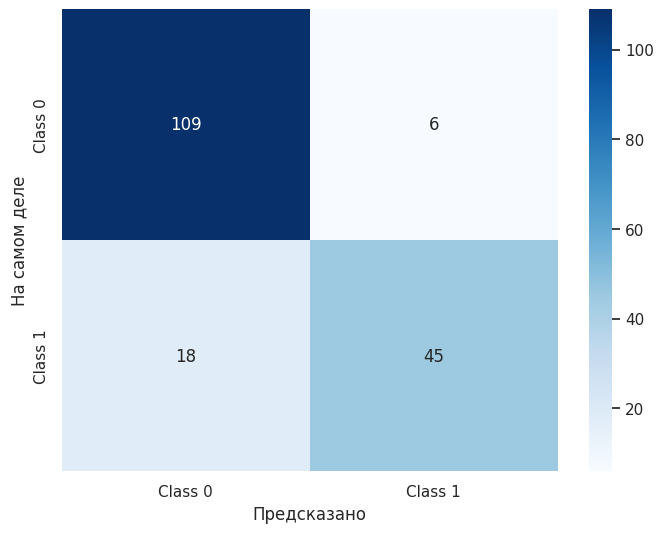

In [70]:
cm = np.array([[109, 6], [18, 45]])
labels = ['Class 0', 'Class 1']

sns.set(style='whitegrid')

# Создание графика
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=labels, yticklabels=labels, ax=ax)

ax.set_xlabel('Предсказано')
ax.set_ylabel('На самом деле')

plt.show()